In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import joblib

In [9]:
df = pd.read_csv("/content/breast-cancer.csv")
print("First 5 rows:\n", df.head())

First 5 rows:
          id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_

In [19]:
target_col = 'diagnosis'  # Change if needed

if df[target_col].dtype == 'object':
    le = LabelEncoder()
    df[target_col] = le.fit_transform(df[target_col])

In [20]:
X = df.drop(columns=[target_col])
y = df[target_col]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=42)

In [24]:
y_pred = svm_clf.predict(X_test_scaled)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Baseline Accuracy: 0.956140350877193

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114


Confusion Matrix:
 [[68  3]
 [ 2 41]]


In [25]:
cv_scores = cross_val_score(svm_clf, X_train_scaled, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))


Cross-validation scores: [0.96703297 0.96703297 0.98901099 0.96703297 0.94505495]
Mean CV Accuracy: 0.9670329670329672


In [26]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid = GridSearchCV(SVC(random_state=42), param_grid, refit=True, cv=5)
grid.fit(X_train_scaled, y_train)

print("\nBest Parameters:", grid.best_params_)
best_svm = grid.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))


Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Tuned Model Accuracy: 0.9736842105263158


In [27]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svm_pca = SVC(kernel='linear', C=grid.best_params_['C'])
svm_pca.fit(X_train_pca, y_train)

SVC(C=10, kernel='linear')

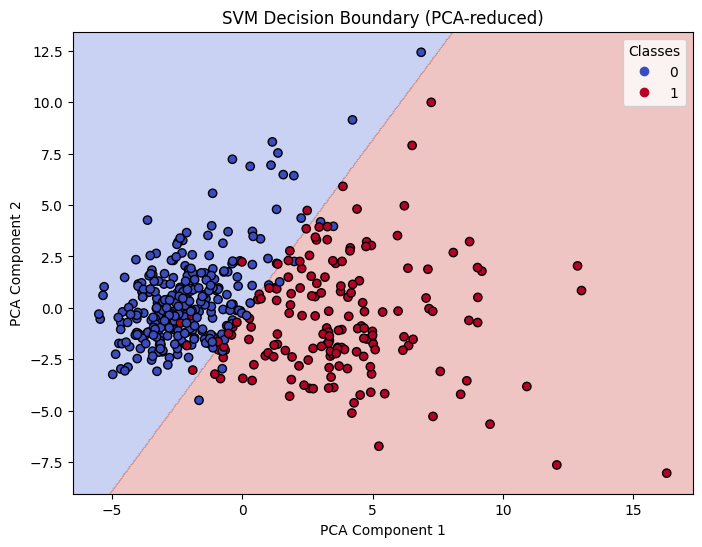

In [28]:
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("SVM Decision Boundary (PCA-reduced)")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()